Christina Bogdan

# Stash Data Analysis

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette(sns.color_palette("deep"))
sns.set()

%matplotlib inline

## Data Load

In [2]:
data_dir = 'etf-data'

In [3]:
buy_events = pd.read_csv(f"{data_dir}/buy_events_subset.csv")
cards = pd.read_csv(f"{data_dir}/cards.csv")
users = pd.read_csv(f"{data_dir}/users_subset.csv")

## Analysis

> 1. Which 5 stocks have the highest volume of purchases?

`buy_events_subset.csv` contains the stock purchase information. 
There is a column named `value`, which is ambiguous. Upon inspection, I saw that this column 
contained, for the most part, integers. Also, the values in the this column varied widely and, upon spot checking, did 
not align with the recent stock price of that stock from `cards`, so I assumed that `value` represented the volume of 
a stock purchased by a user with that particular transaction. To get the total volume purchased of a particular stock, I summed 
up the `value` column of that stock. 

**Note**: It did seem fishy to me that most of the observations in `value` were integers, but there were some that are not. I'm not sure if those non-integers are invalid inputs. In the real world, I would check to make sure 
that this is an acceptable value.

To get the actual name of the stock, I joined `buy_events_subset.csv` to `cards.csv`, which I assumed to be a dataset of 
metadata for various cards. For this join, I filtered `cards.csv` to only include cards where `investment_type='STOCK'`. 
The field `investment_type` has two unique values--`STOCK` and `ETF`. An ETF is a fund that is 
traded on the stock market, but is not actually a stock. I assumed that 'stocks that have the highest volume' only means actual stocks, and not all financials traded on the stock market. For actual stocks, the dataset contains stock purchase information from 
2/22/18 to 7/20/18.

If I was investigating this in the real world, I would have confirmed 
that my assumptions were true with those who knew before sharing the numbers. In this case, I'll just explain my assumptions.

In [4]:
# get total volume per card
buy_volumes = buy_events.groupby('card_id')[['value']].sum().reset_index()

In [5]:
# join purchase info to card metadata
buy_volumes_detail = pd.merge(buy_volumes, cards[cards.investment_type=='STOCK'], left_on=['card_id'], right_on=['id'])

# get top 5 stock volumes for period in buy events
display(buy_volumes_detail.sort_values('value', ascending=False)[['id', 'name', 'value']][:5])

,id,name,value
1,46,Amazon,1431734.99
8,53,Netflix,1165357.89
0,45,Apple,359142.86
7,52,NVIDIA,355255.86
22,67,Tesla,334776.10


The top five stocks by purchase volume are **Amazon, Netfix, Apple, NVIDIA, and Tesla** between 2/22/18 and 7/20/18.

***
> 2. Which 5 stocks have been growing the fastest in purchase volume? 

This is a pretty open question. I'll make some base assumptions:

- We wouldn't want to compare the first buy event in 
`buy_events_subset.csv` to the last, as this doesn't mean much because it's an individual purchase. Instead, I'll aggregate up to the day by summing the `value` column 
for each day.
- The growth rate we care about is that concerning the entire period represented in `buy_events_subset.csv` for stocks -- so 2/22/18 to 7/20/18
- The field `created_at` represents (roughly) the time that the stock was bought
- We care about the growth of a stock from the first day it was bought to the last, not the first day any stock 
is bought in the data to the last


Given these assumptions, the simplest calculation one can do is to get the percent growth from the first day
a particular stock is sold in `buy_events_subset.csv` against the last day. Growth rate is defined as:

$$\text{growth rate} = \frac{\text{value}_{\text{last day}} - \text{value}_{\text{first day}}}{\text{value}_{\text{last day}}} = \frac{\text{value}_{\text{first day}}}{\text{value}_{\text{last day}}} - 1$$

We could just do this calculation on the first and last day that a stock is sold. However, this is not ideal for several reasons:

- The first or last day that a stock is sold could be outliers that dont represent the rest of the volume activity in that time period. The purchase volume 
by day is also periodic--weekends generally have less purchase volume than weekdays across all stocks, so the first/day day being a weekend would affect this metric
- Any trends that occur in the middle of the range are ignored

My approach is to fit a linear regression to the total stock volume for each day. This will give us an 
overall trend line of the volume growth, and we will not have to worry about things like the periodicity introducted by 
the day of the week. I fit one model for each stock.

In [6]:
from sklearn.linear_model import LinearRegression

In [7]:
def model(df: pd.DataFrame):
    """Fit linear regression model of date to purchase volume, 
    and predict on date"""
    necessary_columns = set(['value', 'date_delta'])
    assert len(necessary_columns.intersection(df.columns)) == len(necessary_columns)
    y = df[['value']].values
    X = df[['date_delta']].values
    model = LinearRegression().fit(X, y)
    df['regressed_volume']  = np.squeeze(model.predict(X))
    return df

def group_predictions(df: pd.DataFrame):
    """Apply linear regression to different groups in DF"""
    necessary_columns = set(['created_at_day', 'id'])
    assert len(necessary_columns.intersection(df.columns)) == len(necessary_columns)
    df.created_at_day = pd.to_datetime(df.created_at_day)
    day = np.timedelta64(1, 'D')
    mn = df.created_at_day.min()
    df['date_delta'] = df.created_at_day.sub(mn).div(day)
    return df.groupby('id').apply(model)

def growth_rate(last: float, first: float):
    """Calculate the growth rate between `first` and `last`"""
    return last/first - 1

In [8]:
buy_events['created_at'] = pd.to_datetime(buy_events['created_at'])

In [9]:
card_info_keep_columns = [
    'id',
    'name',
    'investment_type'
]

In [10]:
buy_events_detail = pd.merge(buy_events, 
                             cards[cards.investment_type=='STOCK'][card_info_keep_columns], 
                             left_on=['card_id'], right_on=['id'])

In [11]:
buy_events_detail['created_at_day'] = buy_events_detail['created_at'].apply(lambda d: d.date())

In [12]:
# get total value of a stock by day
buy_events_by_day = buy_events_detail.groupby(['created_at_day', 'id', 'name'])[['value']].sum().reset_index()
# ordinal representatioon of day for plotting
buy_events_by_day['created_at_ordinal'] = buy_events_by_day['created_at_day'].apply(lambda d: d.toordinal())

In [13]:
# get regression predictions for each day
buy_events_by_day = group_predictions(buy_events_by_day)

We'll calculate the volume growth using both the regressed volume and the actual volume on the first and 
last day and compare.

**Note:** We could have also used the regression coefficient to determine the fastest-growing stock volumes. In that case, we 
would have wanted to normalize the volume values before selecting the top five slopes so that they're not biased 
by stocks that have higher purchase volumes in general.

In [14]:
# get volumes on first and last day for each stock
volumes_first_last = buy_events_by_day.sort_values('created_at_day').groupby(['id', 'name']).agg({'regressed_volume':['first', 'last'], 
                                                                                        'value': ['first', 'last']})

In [15]:
# calculate pct growth for regressed volume
reg_pct_growth = volumes_first_last['regressed_volume']
reg_pct_growth['growth_volume'] = reg_pct_growth.apply(lambda r: growth_rate(r['last'], r['first']),axis=1)

/Users/christina.bogdan/miniconda3/envs/stash_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
# calculate pct growth for actual volume
raw_pct_growth = volumes_first_last['value']
raw_pct_growth['growth_volume'] = raw_pct_growth.apply(lambda r: growth_rate(r['last'], r['first']),axis=1)

/Users/christina.bogdan/miniconda3/envs/stash_env/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Five stocks with highest purchase volume, using actual volume on first and last day:

In [17]:
top_5_raw = raw_pct_growth.sort_values('growth_volume', ascending=False)[:5]
top_5_raw_stocks = top_5_raw.reset_index().name.tolist()
display(top_5_raw)

,,first,last,growth_volume
id,name,,,
50,General Electric,0.04,282.79,7068.750000
46,Amazon,10.00,5983.81,597.381000
105,Square,162.00,10970.85,66.721296
48,Facebook,45.00,2817.18,61.604000
108,Merck,5.00,212.19,41.438000


Five stocks with highest purchase volume, using regressed volume on first and last day:

In [18]:
top_5_reg = reg_pct_growth.sort_values('growth_volume', ascending=False)[:5]
top_5_reg_stocks = top_5_reg.reset_index().name.tolist()
display(top_5_reg)

,,first,last,growth_volume
id,name,,,
53,Netflix,615.770460,15458.131471,24.103724
107,Abbvie,493.544151,876.581234,0.776095
104,Mastercard,547.247896,897.658437,0.640314
46,Amazon,7951.037350,11589.037665,0.457550
62,Starbucks,427.521864,574.941544,0.344824


These results are quite different--both the top five companies and the actual percent growth of the volumes are 
very different. We can take a look at what the actual stock purchase volume for these results looks like to see 
what could be happening:

In [19]:
# melt buy events DF for plotting with seaborn
melted_reg = buy_events_by_day.melt(id_vars=['id', 'name', 'created_at_day', 'created_at_ordinal'], 
                                      value_vars=['value', 'regressed_volume'],
                                     value_name='volume', 
                                     var_name='volume_type')

Text(0.5,0.98,'Top Five Stocks by Regressed Volume Growth')

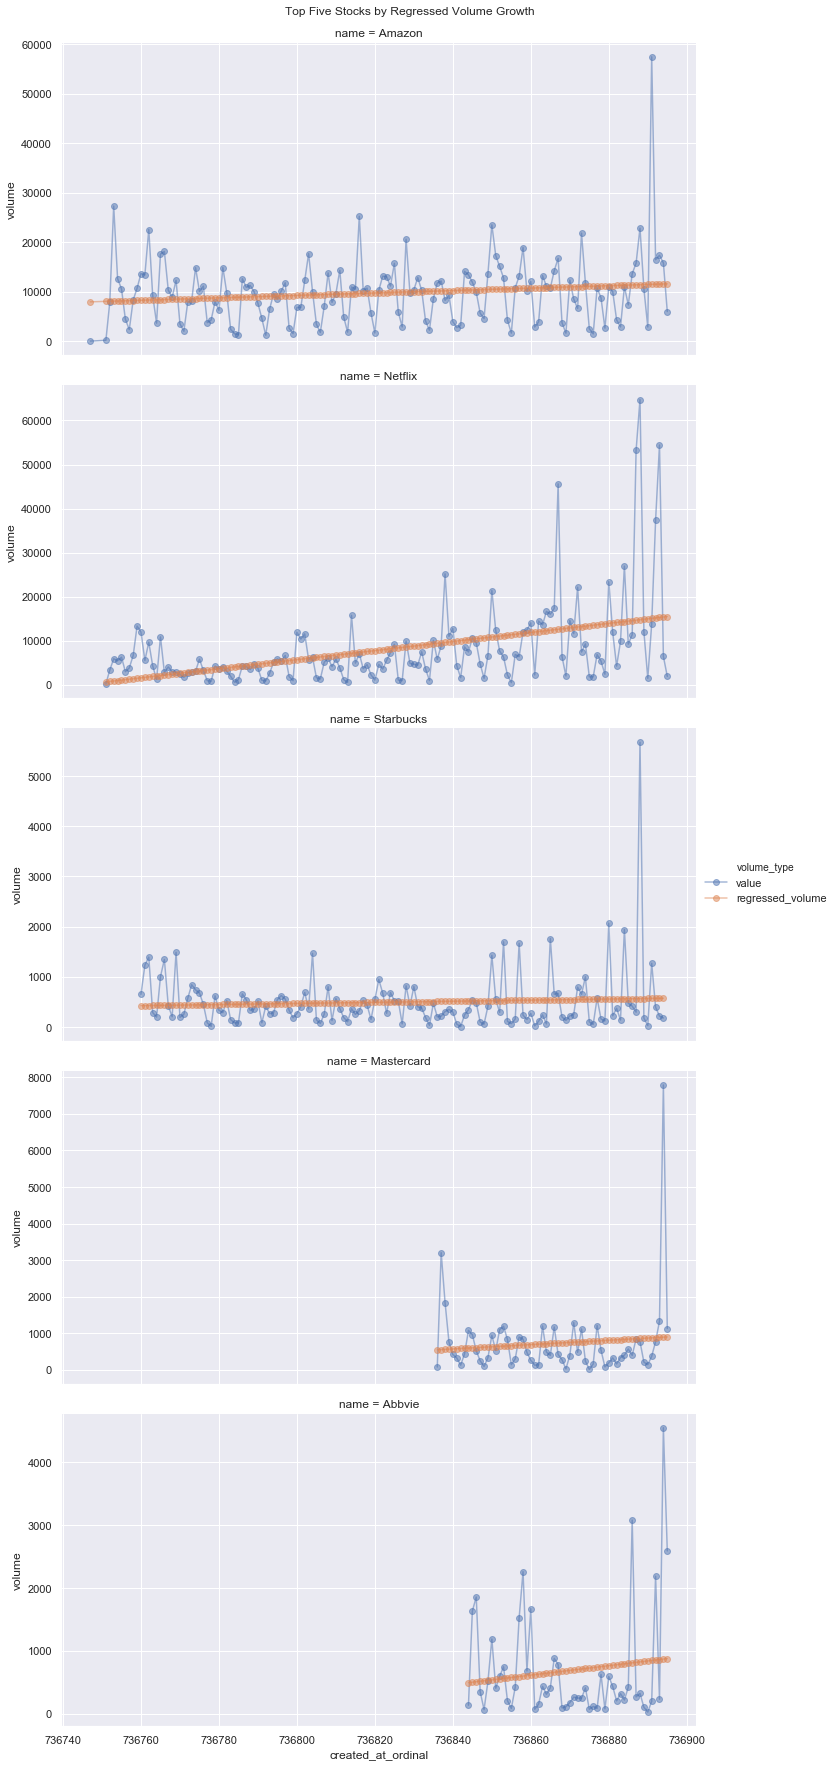

In [20]:
# plot top 5 stocks by regressed volume growth by day
g = sns.FacetGrid(melted_reg[melted_reg.name.isin(top_5_reg_stocks)], 
              row='name', hue='volume_type', aspect=2, height=5, sharey=False).map(plt.plot, 
                                                  'created_at_ordinal', 
                                                  'volume', 
                                                  marker='o', 
                                                  alpha=0.5).add_legend()
plt.subplots_adjust(top=0.96)
g.fig.suptitle('Top Five Stocks by Regressed Volume Growth')

Text(0.5,0.98,'Top Five Stocks by Raw Volume Growth')

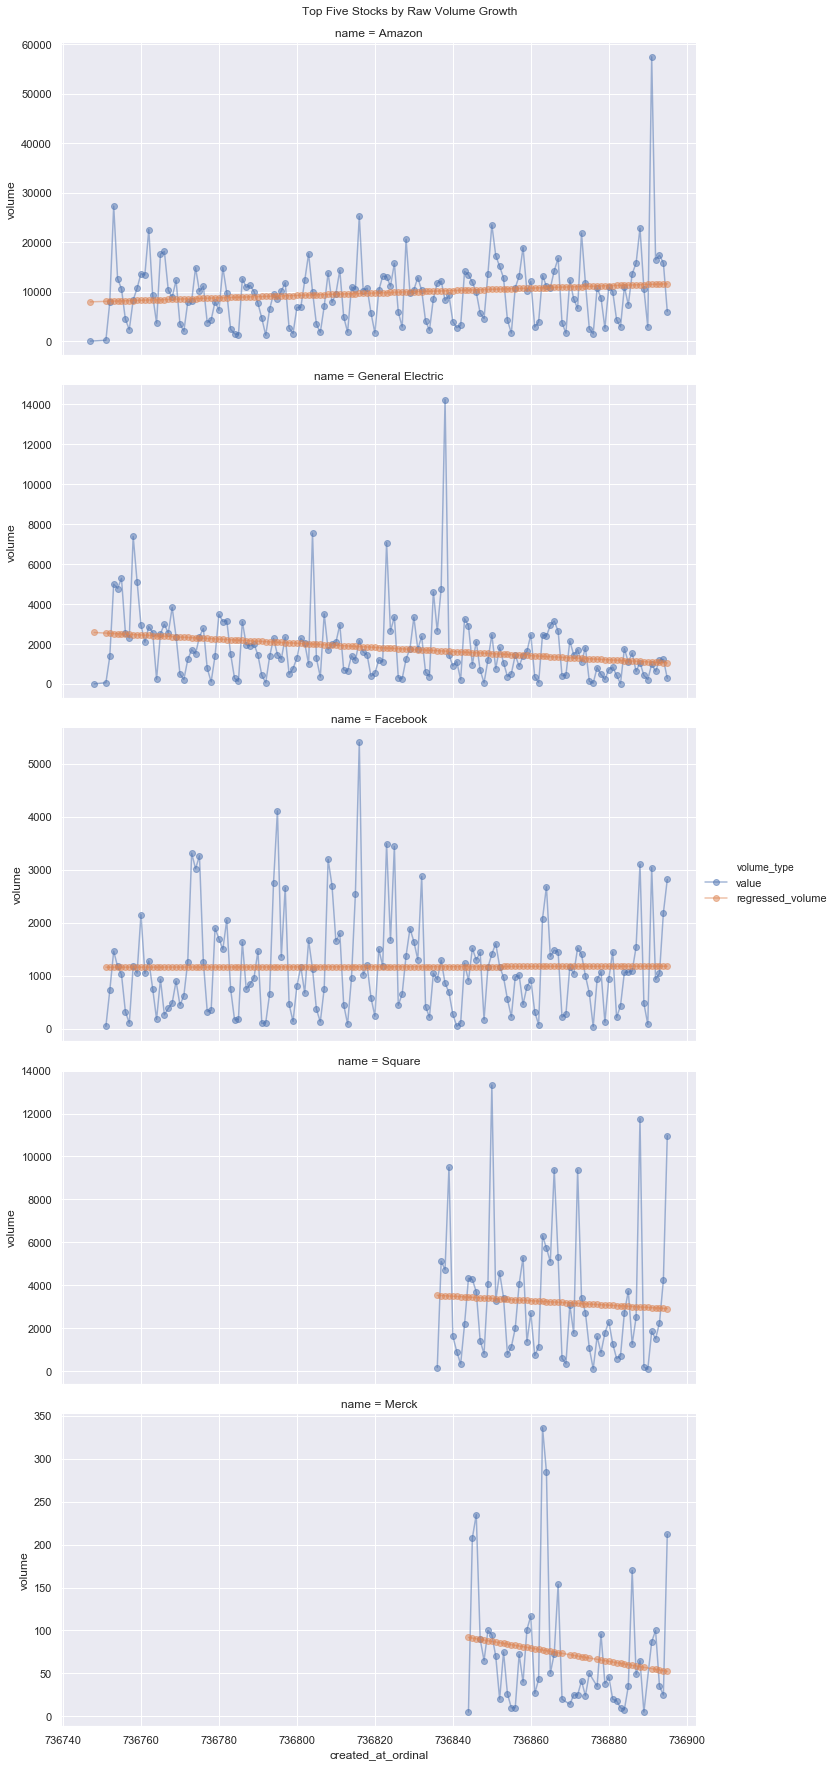

In [21]:
# plot top 5 stocks by raw volume growth by day
g = sns.FacetGrid(melted_reg[melted_reg.name.isin(top_5_raw_stocks)], 
              row='name', hue='volume_type', aspect=2, height=5, sharey=False).map(plt.plot, 
                                                  'created_at_ordinal', 
                                                  'volume', 
                                                  marker='o', 
                                                  alpha=0.5).add_legend()
plt.subplots_adjust(top=0.96)
g.fig.suptitle('Top Five Stocks by Raw Volume Growth')

With the exception of Amazon, I would not say that the stocks produced by calculating growth using the volumes on the 
first and last day are actually growing. These results could also be caused by outliers in the data (a result from how it 
was collected?) For example, on the first day that General Electric was bought, the total volume was `0.04`, which is what 
give it such a large growth rate.

The stocks produced using the regressed volume are definitely growing, and their rankings make sense to me as well. Thus, 
I will conclude that *the top five stocks that have been growing the fastest in purchase volume are*
**Netflix, Abbvie, MasterCard, Amazon, and Starbucks**

In [22]:
display(top_5_reg)

,,first,last,growth_volume
id,name,,,
53,Netflix,615.770460,15458.131471,24.103724
107,Abbvie,493.544151,876.581234,0.776095
104,Mastercard,547.247896,897.658437,0.640314
46,Amazon,7951.037350,11589.037665,0.457550
62,Starbucks,427.521864,574.941544,0.344824


***

> 3. Based on the data, what do you think drives a user to make a purchase? What would you recommend to the business to increase user purchases? What other data would you want?

Some useful information that we have readily available is: 

- **Discover events**: A user viewing the discover page of a stock/etf before purchasing
- **Bookmark events**: A user bookmarking the stock/etc before purchasing
- **User metadata**: Information like employment status, risk level
- **Card metadata**: Information like the investment type, and some of the other properties. We have to be careful here though, 
because some of the information in this dataset may have been updated after a user purchased the stock, and can contain 
information that is dependent on users purchasing that investment in the past

We can also calculate information around what users' past purchase activity is:

- What volume of that investment did that user purchase previously?
- Did the user purchase a lot of other investments in the past few days?
- Did the user purchase a lot of investments in general?

To get an idea of what drives a user to make a purchase, we can compare the overall probability of a purchase 
against the probability of making a purchase given that we observed a certain variable of interest 
(or a combination of some variables).

We can say that probability of making a purchase is:

$$P(purchase) = \frac{N_\text{purchases}}{N_\text{purchases and non-purchases}}$$

But a purchase can happen at any time--it is continuous. We can simplify by aggregating the data to 
see if a user made a purchase of a particular investment *on a specific day*. Then, we can count 
non-purchases by summing up number of stocks that a user could have purchased on a given day. So:

$$P(purchase)  = \frac{N_\text{purchases}}{N_\text{users} \cdot N_\text{stocks} \cdot N_\text{days}}$$

I will talk about how I define the number of stocks/days later.

In [24]:
buy_events = pd.read_csv(f"{data_dir}/buy_events_subset.csv")  # reload buy events to start fresh
buy_events['created_at'] = pd.to_datetime(buy_events['created_at'])
buy_events['event_day'] = buy_events['created_at'].apply(lambda d: d.date()) # get full day

cards = pd.read_csv(f"{data_dir}/cards.csv")  # reload cards
cards['created_at'] = pd.to_datetime(cards['created_at'])
cards = cards.rename(columns={'risk_level': 'risk_level_card', 
                             'created_at': 'created_at_card'})  # rename because of overlap with risk_level in users
cards['created_at_day_card'] = cards['created_at_card'].apply(lambda d: d.date())

users = pd.read_csv(f"{data_dir}/users_subset.csv")
users = users.rename(columns={'risk_level': 'risk_level_user'}) #  rename because of overlap with risk_level in cards

In [25]:
# add name col to buy events
buy_events = pd.merge(buy_events, cards[['id', 'name']], left_on=['card_id'], right_on=['id'])

### Get User Discover Events by Day

In [26]:
discover_events = pd.read_csv(f"{data_dir}/discover_events_subset.csv")

I noticed that `discover_events_subset.csv` contains duplicate rows. I'll drop the duplicates.

In [27]:
discover_events = discover_events.drop_duplicates()

That datset also contains discover events by users who are not in `users_subset.csv`. 
I'll inner join with the users DF to only get events from users who we have metadata for. 
I'll also use this join to get the `user_id` column.

In [28]:
discover_events = pd.merge(discover_events, users[['uuid', 'user_id']], on=['uuid'])

discover_events['datetime'] = pd.to_datetime(discover_events['datetime'])
discover_events['event_day'] = discover_events['datetime'].apply(lambda d: d.date())

In [29]:
# get number of discover events by user by day
user_discover_events_day = discover_events.groupby(['user_id', 'event_day'])[['datetime']].count().reset_index()
user_discover_events_day.describe()

,user_id,datetime
count,1.476360e+05,147636.000000
mean,2.941567e+06,6.358917
std,1.163851e+06,10.140185
min,3.600000e+01,1.000000
25%,2.101187e+06,1.000000
50%,3.330506e+06,3.000000
75%,3.919141e+06,7.000000
max,4.288469e+06,376.000000


It is strange that a user would have over 100 discover events in a single day. I'm just going to assume they are bots, or 
employees testing something. And exclude them from everything. With access to the system that generated the data/more data, I 
would actually investigate to see what is going on here

In [31]:
# filter out users with more than 100 discover events in a day
exclude_users = set(user_discover_events_day[user_discover_events_day.datetime > 100].user_id.tolist())

discover_events = discover_events[~discover_events.user_id.isin(exclude_users)]

In [32]:
# get discover events that happened on the same day as a purchase
discover_purchases = pd.merge(discover_events, buy_events, 
                              on=['event_day', 'name', 'user_id'], 
                              suffixes=['_discover', '_purchase'])

# filter this to only count discover events that happened before purchase
discover_purchases = discover_purchases[discover_purchases.created_at >= discover_purchases.datetime]

In [33]:
# only care if a user visited discover on that day at least once
discover_purchases_by_day = discover_purchases[['name', 'user_id', 'uuid', 'event_day',]].drop_duplicates()
discover_purchases_by_day['did_purchase_discover'] = True

In [34]:
# get all cards that user discovered on a day (again, dont care how many times they did it)
discover_by_day = discover_events[['uuid', 'name', 'user_id', 'event_day']].drop_duplicates()

# see which days had discover events before a purchase
discover_by_day = pd.merge(discover_by_day, discover_purchases_by_day, 
                                     on=['uuid', 'name', 'user_id', 'event_day'],
                                    how='left')

# if this is null, no discover event on that day led to a purchase
discover_by_day['did_purchase_discover'] = discover_by_day['did_purchase_discover'].fillna(False)
discover_by_day['did_discover'] = True

### Get User Bookmark Events by Day

In [35]:
bookmark_events = pd.read_csv(f"{data_dir}/bookmark_events_subset.csv")

# get card name as well as id
bookmark_events = pd.merge(bookmark_events, cards[['id', 'name']], left_on=['card_id'], right_on=['id']).drop('id', axis=1)
bookmark_events['created_at'] = pd.to_datetime(bookmark_events['created_at'])
bookmark_events['event_day'] = bookmark_events['created_at'].apply(lambda d: d.date())  # get full day

bookmark_events = bookmark_events[~bookmark_events.user_id.isin(exclude_users)]  # remove excluded users

In [36]:
# get bookmark events that happened on the same day as a purchase
bookmark_purchases = pd.merge(bookmark_events, buy_events, 
                              on=['event_day', 'name', 'user_id'], 
                              suffixes=['_bookmark', '_purchase'])

# filter this to only count bookmark events that happened before purchase
bookmark_purchases = bookmark_purchases[bookmark_purchases.created_at_purchase >= bookmark_purchases.created_at_bookmark]

In [37]:
# only care about at least one bookmark happening, so drop if there are multiple events
bookmark_purchases_by_day = bookmark_purchases[['name', 'user_id', 'event_day',]].drop_duplicates()
bookmark_purchases_by_day['did_purchase_bookmark'] = True

In [38]:
# get all cards that user bookmarked on a day
bookmark_by_day = bookmark_events[['name', 'user_id', 'event_day']].drop_duplicates()

# add flag if user bookmarked prior to purchase
bookmark_by_day = pd.merge(bookmark_by_day, bookmark_purchases_by_day, 
                                     on=['name', 'user_id', 'event_day'],
                                    how='left')

# if this is null, no bookmark event on that day led to a purchase
bookmark_by_day['did_purchase_bookmark'] = bookmark_by_day['did_purchase_bookmark'].fillna(False)
bookmark_by_day['did_bookmark'] = True

### Derive Probabilities

Now that we have the bookmark/discover information by day, we can start deriving the probabilities of 
a user purchasing a particular investment. Like I said before, I'm defining:


$$P(purchase)  = \frac{N_\text{purchases}}{N_\text{users} \cdot N_\text{stocks} \cdot N_\text{days}}$$

In `users_subset.csv`, we dont have any indicator of when a user opened their account so we'll say $N_\text{users}$ is the 
number of unique users in `users_subset.csv`. 

$N_\text{stocks} \cdot N_\text{days}$ is more complicated, because the `created_at` field in `cards.csv` suggests that 
not all stocks were available to purchase on every day represented in `buy_events_subset.csv`. For each day, we 
only want to count how many stocks were actually availble to purchase on that day.

I'll say that the date range we want to look at is the range represented in `buy_events_subset.csv` (9/17/15 to 7/20/18). 
I will add a column to the buy events DF containing the number of days that that stock was available. Summing all of the 
rows for that will give us $N_\text{stocks} \cdot N_\text{days}$.

In [39]:
max_date = buy_events.created_at.max()  # get last time purchase was made
min_date = buy_events.created_at.min() # get first time purchase was made

In [40]:
cards['days_stock_avail'] = cards['created_at_card'].apply(lambda d: (max_date - d).days)  # get num days investment was available

In [41]:
# get number of user/stock/day purchases DF
user_purchases_by_day = buy_events.groupby(['card_id', 'user_id', 'event_day',])[['value']].count().rename(
    columns={'value': 'num_buy_events'}).reset_index()

# filter user users excluded from weird discover events
user_purchases_by_day = user_purchases_by_day[~user_purchases_by_day.user_id.isin(exclude_users)]

In [43]:
n_card_days = (cards.days_stock_avail.sum())  # this is N_stocks * N_days
n_users = len(users.user_id.unique())  # N_users

In [44]:
# probability of making a purchase
p_buy = len(user_purchases_by_day) / (n_card_days * n_users)
# p(purchase | discover before purchase on that day)
p_buy_discover = discover_by_day['did_purchase_discover'].sum()/len(discover_by_day)
# p(purchase | bookmark before purchase on that day)
p_buy_bookmark = bookmark_by_day['did_purchase_bookmark'].sum()/len(bookmark_by_day)

What if a user bookmarks *and* discovers an investment before purchasing it? That could mean that they're really interested, 
so let's also look at this probability

In [45]:
bookmark_and_discover = pd.merge(bookmark_by_day, discover_by_day, on=['user_id', 'name', 'event_day'], how='inner')

bookmark_and_discover['did_discover'] = bookmark_and_discover['did_discover'].fillna(False)
bookmark_and_discover['did_bookmark'] = bookmark_and_discover['did_bookmark'].fillna(False)
bookmark_and_discover['did_purchase_bookmark'] = bookmark_and_discover['did_purchase_bookmark'].fillna(False)
bookmark_and_discover['did_purchase_discover'] = bookmark_and_discover['did_purchase_discover'].fillna(False)

In [46]:
p_buy_bm_discover = (bookmark_and_discover['did_purchase_bookmark'] & \
                     bookmark_and_discover['did_purchase_discover']).sum() / len(bookmark_and_discover)

Let's look at the probabilities we have so far:

In [47]:
print(f"P(Purchase): {round(p_buy, 5)}")
print(f"P(Purchase | Bookmark): {round(p_buy_bookmark, 3)}")
print(f"P(Purchase | Discover): {round(p_buy_discover, 3)}")
print(f"P(Purchase | Discover, Bookmark)= {round(p_buy_bm_discover, 3)}")

P(Purchase): 0.00083
P(Purchase | Bookmark): 0.08
P(Purchase | Discover): 0.094
P(Purchase | Discover, Bookmark)= 0.154


Users are way more likely to purchase a stock if they bookmarked or discovered it beforehand, and if they did both, 
they are even more likely.

Users bookmarking the stock/etf prior to the day it was bought is probably also a good indicator. This would be something to 
do in the future.

## Calculating P(purchase | previous purchases >= x)

If a user has had several purchases before, they may be more likely to purchase something again.

In [48]:
from datetime import timedelta

In [49]:
def get_valid_cards_by_day():
    """Get how many cards were available to be bought on each date"""
    # get all days we observe purchases
    dates = [(min_date + timedelta(days=i)).date() for i in range((max_date-min_date).days+2)]
    # get all cards valid on each day
    cards_valid = [len(cards[cards.created_at_day_card <= date]) for date in dates]
    # create a DF with this information
    valid_cards_df = pd.DataFrame([dates, cards_valid]).T
    valid_cards_df.columns = ['event_day', 'n_valid_cards']
    return valid_cards_df.sort_values('event_day')

In [50]:
valid_cards_by_day = get_valid_cards_by_day()

In [51]:
user_purchases_by_day = user_purchases_by_day.sort_values('event_day')  # sort so group by looking at prev row works
# get number of user card purchases until this date
user_purchases_by_day['card_purchases_to_date'] = user_purchases_by_day.groupby(['user_id', 'card_id'])['num_buy_events'].apply(lambda x: x.shift(1).cumsum().fillna(0))
# get total number of user purchases until this date
user_purchases_by_day['user_purchases_to_date'] = user_purchases_by_day.groupby(['user_id'])['num_buy_events'].apply(lambda x: x.shift(1).cumsum().fillna(0))

In [52]:
user_purchases_by_day[['card_purchases_to_date', 'user_purchases_to_date']].describe()

,card_purchases_to_date,user_purchases_to_date
count,1.850581e+06,1.850581e+06
mean,9.838234e+00,1.024526e+02
std,1.531308e+01,1.791544e+02
min,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.400000e+01
50%,4.000000e+00,4.300000e+01
75%,1.200000e+01,1.150000e+02
max,4.170000e+02,3.242000e+03


Interesting how there are some user(s) that have up to 3,000 purchase events. Perhaps this isn't a real user?

In [57]:
user_purchases_by_day[user_purchases_by_day.user_purchases_to_date > 3000].user_id.unique()

array([697155])

It looks like there is only one user who falls into this bucket. Valid or not, I'll consider them as an outlier. 
I think it only looks to make sense to look at P(purchase | user/card purchases to date) for values way less than the 
maximums here. We definitely don't want the probabilities to reflect the actions of just one user.

In [58]:
def get_cum_purchase_probabilities(threshold_col, min_threshold=10, max_threshold=400, bin_range=50):
    """Get list of P(purchase | threshold_col >= threshol) for varying thresholds"""
    def _get_threshold_prob(threshold):
        purchases_above_threshold = user_purchases_by_day[user_purchases_by_day[threshold_col] >= threshold]
        users_thresh_day = purchases_above_threshold.groupby(['event_day'])['user_id'].unique().reset_index()
        users_thresh_day['user_id'] = users_thresh_day['user_id'].apply(lambda x: set(x))
        cum_users_thresh_by_day = pd.merge(valid_cards_by_day, users_thresh_day, 
                        on=['event_day'], how='outer').sort_values('event_day')
        
        curr_valid_users = set([])
        day_valid_rows = []
        for i, row in cum_users_thresh_by_day.iterrows():
            if not pd.isnull(row.user_id):
                curr_valid_users = curr_valid_users.union(row.user_id)
            day_valid_rows.append(len(curr_valid_users))
        cum_users_thresh_by_day['n_valid_users'] = day_valid_rows
        cum_users_thresh_by_day['total_valid'] = cum_users_thresh_by_day['n_valid_cards'] * cum_users_thresh_by_day['n_valid_users']
        print(f"threshold={threshold}; num purchases above={len(purchases_above_threshold)}; num users={len(curr_valid_users)}")
        p_purchase_threshold = len(purchases_above_threshold) / cum_users_thresh_by_day['total_valid'].sum()
        return p_purchase_threshold
    threshold_bins = np.arange(min_threshold, max_threshold+bin_range, bin_range)
    probabilities = [_get_threshold_prob(threshold) for threshold in threshold_bins]
    return threshold_bins, probabilities

threshold=10; num purchases above=575821; num users=12256
threshold=20; num purchases above=293189; num users=5827
threshold=30; num purchases above=164656; num users=3348
threshold=40; num purchases above=94738; num users=2047
threshold=50; num purchases above=54206; num users=1219
threshold=60; num purchases above=30808; num users=740
threshold=70; num purchases above=17479; num users=471
threshold=80; num purchases above=9880; num users=279
threshold=90; num purchases above=5504; num users=164
threshold=100; num purchases above=3281; num users=85


Text(0,0.5,'p(purchase | card_purchases_to_date=x)')

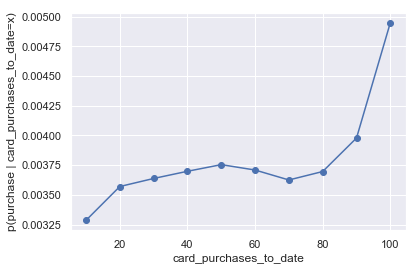

In [59]:
probs_given_card_purchases_to_date = get_cum_purchase_probabilities('card_purchases_to_date', max_threshold=100, bin_range=10)

plt.plot(probs_given_card_purchases_to_date[0], probs_given_card_purchases_to_date[1], marker='o')
plt.xlabel('card_purchases_to_date')
plt.ylabel('p(purchase | card_purchases_to_date=x)')

threshold=10; num purchases above=1510447; num users=27600
threshold=30; num purchases above=1105837; num users=15196
threshold=50; num purchases above=861719; num users=9967
threshold=70; num purchases above=696233; num users=7022
threshold=90; num purchases above=576030; num users=5281
threshold=110; num purchases above=485022; num users=4071
threshold=130; num purchases above=413634; num users=3263
threshold=150; num purchases above=356178; num users=2646
threshold=170; num purchases above=309294; num users=2171
threshold=190; num purchases above=270726; num users=1776
threshold=210; num purchases above=238491; num users=1508
threshold=230; num purchases above=211425; num users=1274
threshold=250; num purchases above=188237; num users=1098
threshold=270; num purchases above=168394; num users=941
threshold=290; num purchases above=151290; num users=818
threshold=310; num purchases above=136477; num users=719


Text(0,0.5,'p(purchase | user_purchases_to_date=x)')

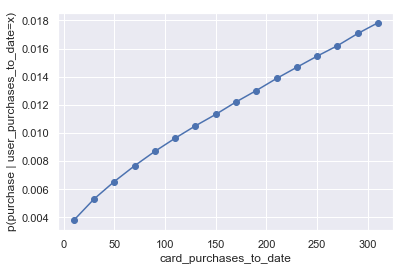

In [60]:
probs_given_user_purchases_to_date = get_cum_purchase_probabilities('user_purchases_to_date', max_threshold=300, bin_range=20)

plt.plot(probs_given_user_purchases_to_date[0], probs_given_user_purchases_to_date[1], marker='o')
plt.xlabel('card_purchases_to_date')
plt.ylabel('p(purchase | user_purchases_to_date=x)')

As we increase the threshold on user/user x card purchases to date, the probability of purchasing increases. 
However, when we increase the threshold we also have less users that fall into that bucket. If we wanted to use this 
information to do some targeting, we'd have to be conscious that as it increases we have fewer users. But also, 
maybe we wouldn't want to target these users since they're likely to buy anyway.

Let's get the threshold and corresponding probability that gives us the highest probability of purchasing:

In [61]:
max_past_user_idx = np.argmax(probs_given_user_purchases_to_date[1])
p_purchase_given_past_user = probs_given_user_purchases_to_date[1][max_past_user_idx]
p_given_past_user_thresh = probs_given_user_purchases_to_date[0][max_past_user_idx]

In [62]:
print(f"P(purchase | user_purchases_to_date >= {p_given_past_user_thresh}) = {round(p_purchase_given_past_user, 3)}")

P(purchase | user_purchases_to_date >= 310) = 0.018


In [63]:
max_past_card_idx = np.argmax(probs_given_card_purchases_to_date[1])
p_purchase_given_past_card = probs_given_card_purchases_to_date[1][max_past_card_idx]
p_given_past_card_thresh = probs_given_card_purchases_to_date[0][max_past_card_idx]

In [64]:
print(f"P(purchase | card_purchases_to_date >= {p_given_past_card_thresh}) = {round(p_purchase_given_past_card, 3)}")

P(purchase | card_purchases_to_date >= 100) = 0.005


#### Get Card and User Metadata

Now we can look at the probabilities of purchasing given certain user/investment attributes.

In [65]:
# attach all card/user metadata
user_purchases_by_day = pd.merge(user_purchases_by_day, 
                                 users, 
                                 on=['user_id'], 
                                 suffixes=['_purchase', '_user'])
user_purchases_by_day = pd.merge(user_purchases_by_day, 
                                 cards, 
                                 left_on=['card_id'], 
                                 right_on=['id'], 
                                 suffixes=['_purchase', '_card'])

We'll call out what specific variables could be of interest in telling us if a purchase will happen:

In [66]:
# continuous variables in cards data
card_cont_cols = [
    'risk_level_card',
    'dividend_rate_percent',
    'expense_ratio_percent',
    'one_day_change_percent',
    'year_to_date_change_percent',
]

# catagorical variables in cards data
card_cat_cols = [
    'investment_type'
]

# continuous user attributes
user_cont_cols = [
    'risk_level_user',
    'age',
    'total_net_worth_range',
    'federal_tax_bracket_percent',
]

# categorical user attributes
user_cat_cols = [
    'employment_status'
]

For continuous variables, we're not just interested in the probability of a purchase at a specific value, 
but rather the probability of purchasing given we are above/below some value.

In [67]:
"""Helper functions for deriving probabilities for continuous/categorical variables"""

def make_bins(values, n_bins=50):
    """Create bins from a list of continuous values. If we have above 
    n_bins, we will create bins, otherwise just use the original values"""
    unq_values = values.unique()
    if len(unq_values > n_bins):
        min_val = min(unq_values)
        max_val = max(unq_values)
        return np.arange(min_val, max_val + 1, (max_val + 1 - min_val)/n_bins)
    return sorted(unq_values)

def bin_p_purchase(buy_df, bin_filt_df,  
                   total_n_users=n_users, 
                   total_n_card_days=n_card_days):
    """
    Get probability of making a purchase given a filter
    
    Parameters
    ----------
    buy_df : pd.DataFrame
        DF of purchase information
    bin_filt_df: pd.DataFrame
        DF containing filter on a specific value (filtered card or user DF)
    total_n_users: int
        total number of unique users (to speed up calculations)
    total_n_card_days: int
        total number of cards x days available (to speed up calculations)
    """
    # filtering on users df
    if 'user_id' in bin_filt_df.columns:
        # merge to purchases to get num purchase | filter
        buys_bin = pd.merge(buy_df, bin_filt_df[['user_id']], on=['user_id'])
        # get new number of users
        n_users = len(bin_filt_df.user_id.unique())
        # num cards x days is the same
        n_card_days = total_n_card_days
        
    # else, we are filtering on cards df
    else:
        buys_bin = pd.merge(buy_df, bin_filt_df[['id']], on=['id'])
        # num users is the same
        n_users = total_n_users
        # get new num purchase x days
        n_card_days = bin_filt_df.days_stock_avail.sum()
        
    # get probability of purchase | variable
    p_purchase = len(buys_bin) / (n_users * n_card_days)
    return p_purchase

def continuous_purchase_probs(buy_df, filt_df, filt_col):
    # create bins for continuous variables
    bins = make_bins(filt_df[filt_col], n_bins=10)
    # get filtered metadata df on bin value
    filt_dfs = [filt_df[filt_df[filt_col] >= bin_value] for bin_value in bins]
    # get probabilities | filter
    p_purchases = [bin_p_purchase(buy_df, bin_filt_df) for bin_filt_df in filt_dfs]
    return bins, p_purchases

def categorical_purchase_probs(buy_df, filt_df, filt_col):
    # get unique categories for `filt_col`
    categories = filt_df[filt_col].unique()
    # get dfs filterd on `filt_col` value
    filt_dfs = [filt_df[filt_df[filt_col] == category] for category in categories]
    # get probs | filter
    p_purchases = [bin_p_purchase(buy_df, cat_filt_df) for cat_filt_df in filt_dfs]
    return categories, p_purchases

In [68]:
def make_cont_probability_plots(var_prob_dict):
    """Helper function to make plots of probabilities of purchase for 
    a continuous variable by thresholds on that variable
    
    Parameters
    ----------
    var_prob_dict: dict
        Dict of format {'var_name': (threshold_bins, probabilities)}
    """
    import math
    ncol = 3
    nrow = math.ceil(len(card_cont_cols)/ncol)
    f, axarr = plt.subplots(ncol, nrow, figsize=(14,14), sharey=True)
    axarr = axarr.flatten()
    for i, var in enumerate(var_prob_dict.keys()):
        bins, pp = var_prob_dict[var]
        ax = axarr[i]
        ax.plot(bins, pp, marker='o')
        ax.set_xlabel(var)
        ax.set_ylabel('P(purchase|var)')
        ax.set_title(f'P(purchase|{var}) by Threshold')

    # hide unused subplots
    if i < len(axarr):
        for j in range(i+1, len(axarr)):
            axarr[j].set_visible(False)
    plt.tight_layout()
    plt.show()
    
def make_cat_probability_plots(var_prob_dict):
    """Helper function to make plots of probabilities of purchase for 
    a categorical variable by thresholds on that variable
    
    Parameters
    ----------
    var_prob_dict: dict
        Dict of format {'var_name': (var_value, probabilities)}
    """
    import math
    ncol = 3
    nrow = math.ceil(len(card_cont_cols)/ncol)
    f, axarr = plt.subplots(ncol, nrow, figsize=(14,14), sharey=True)
    axarr = axarr.flatten()
    for i, var in enumerate(var_prob_dict.keys()):
        var_value, pp = var_prob_dict[var]
        ax = axarr[i]
        ax.bar(np.arange(len(pp)), pp, tick_label=var_value)
        ax.set_xlabel(var)
        ax.set_ylabel('P(purchase|var)')
        ax.set_title(f'P(purchase|{var}) by Column Value')

    # hide unused subplots
    if i < len(axarr):
        for j in range(i+1, len(axarr)):
            axarr[j].set_visible(False)
    plt.tight_layout()
    plt.show()

In [69]:
"""Get probabilities of purchasing for various continuous/categorical variables in users/cards dfs"""

# continuous card attribute probs
continuous_card_vars_probabilities = {var : continuous_purchase_probs(user_purchases_by_day, cards, var) 
                                     for var in card_cont_cols}

# continuous user attribute probs
continuous_user_vars_probabilities = {var : continuous_purchase_probs(user_purchases_by_day, users, var) 
                                     for var in user_cont_cols}

# categorical user attribute probs
cat_user_vars_probabilities = {var : categorical_purchase_probs(user_purchases_by_day, users, var) 
                                     for var in user_cat_cols}

# categorical card attribute probs
cat_card_vars_probabilities = {var : categorical_purchase_probs(user_purchases_by_day, cards, var) 
                                     for var in card_cat_cols}

/Users/christina.bogdan/miniconda3/envs/stash_env/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in long_scalars
/Users/christina.bogdan/miniconda3/envs/stash_env/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


Probability of purchase given continuous attributes in `cards.csv`:

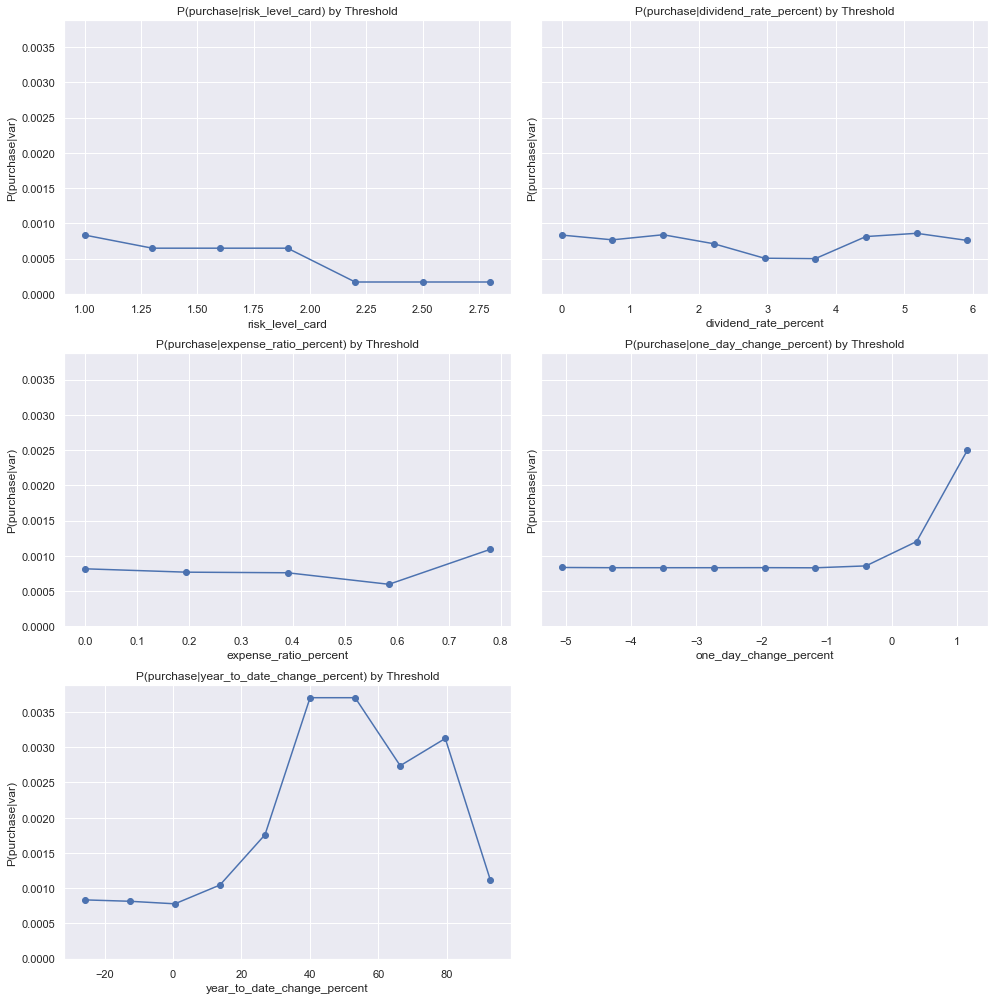

In [70]:
make_cont_probability_plots(continuous_card_vars_probabilities)

Probability of purchase given continuous attributes in `users_subset.csv`:

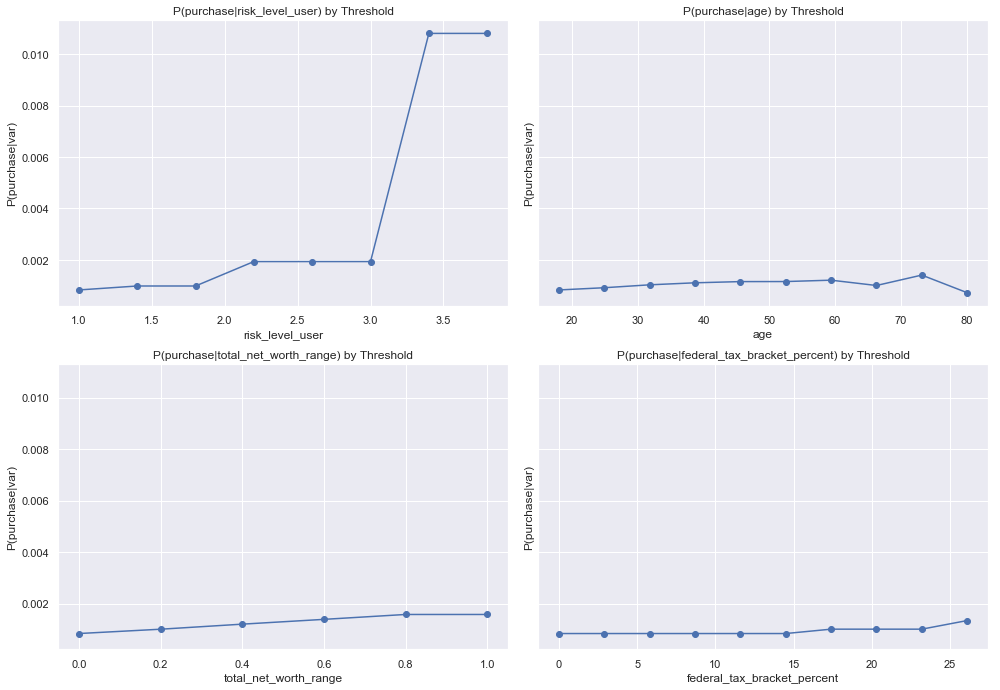

In [71]:
make_cont_probability_plots(continuous_user_vars_probabilities)

It's interesting that users with higher risk levels have such a large probability of purchasing (almost 1%). 
But maybe something else is going on. Let's look at the data:

In [72]:
users[users.risk_level_user > 3]

,user_id,federal_tax_bracket_percent,employment_status,liquidity_needs,total_net_worth_range,age,uuid,risk_level_user
224,156238,28.0,EMPLOYED,0.0,1.0,29,4f0ca53e-1d55-4752-984d-384530fcee3b,4
1733,455500,28.0,UNEMPLOYED,0.0,1.0,35,4bcacd55-5990-41e0-8790-3b88e59339c1,4
12904,2122279,28.0,EMPLOYED,0.0,1.0,25,467d405b-4688-4b23-9589-ee9b6a984a45,4
17017,2645396,28.0,EMPLOYED,0.0,1.0,45,21f17dac-30ab-49fd-93c8-20031efb7a89,4
36232,3961649,28.0,EMPLOYED,0.5,1.0,32,35ea0189-5fac-4e3b-8946-fc69aab11085,4


In [73]:
len(user_purchases_by_day[user_purchases_by_day.risk_level_user > 3])

2414

These users make up such a small subset of our overall data. Maybe it isn't the best idea to trust this probability 
given that it is derived from such a small set of users. We see something similar for users older than 75:

In [74]:
users[users.age > 75].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19 entries, 675 to 45180
Data columns (total 8 columns):
user_id                        19 non-null int64
federal_tax_bracket_percent    19 non-null float64
employment_status              19 non-null object
liquidity_needs                19 non-null float64
total_net_worth_range          19 non-null float64
age                            19 non-null int64
uuid                           19 non-null object
risk_level_user                19 non-null int64
dtypes: float64(3), int64(3), object(2)
memory usage: 1.3+ KB


In [75]:
len(user_purchases_by_day[user_purchases_by_day.age > 75])

1346

Probability of purchase given categorical attributes in `cards.csv`:

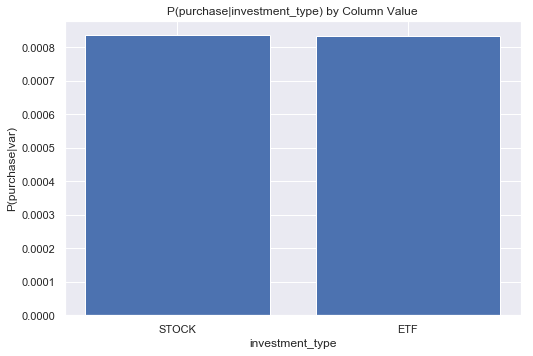

In [76]:
make_cat_probability_plots(cat_card_vars_probabilities)

Probability of purchase given categorical attributes in `users_subset.csv`:

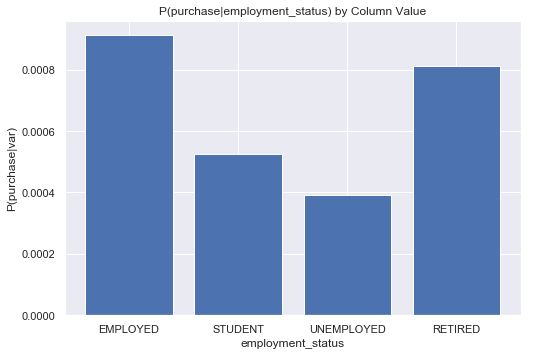

In [77]:
make_cat_probability_plots(cat_user_vars_probabilities)

Now we combine all the probabilities we've derived and look at them all together:

In [78]:
def get_max_prob_value(val_name, prob):
    max_prob = max(prob)
    max_prob_idx = prob.index(max_prob)
    return val_name[max_prob_idx], max_prob

In [79]:
cat_vars_probs = dict(cat_user_vars_probabilities, **cat_card_vars_probabilities)
cat_vars_probs = {k: (get_max_prob_value(*v)) for k,v in cat_vars_probs.items()}
cat_vars_probs = {f"{k}={v[0]}": v[1] for k, v in cat_vars_probs.items()}

In [80]:
cont_vars_probs = dict(continuous_user_vars_probabilities, **continuous_card_vars_probabilities)
cont_vars_probs = {k: (get_max_prob_value(*v)) for k,v in cont_vars_probs.items()}
cont_vars_probs = {f"{k}>={round(v[0], 2)}": v[1] for k, v in cont_vars_probs.items()}

In [81]:
max_past_user_idx = np.argmax(probs_given_user_purchases_to_date[1])
p_purchase_given_past_user = probs_given_user_purchases_to_date[1][max_past_user_idx]
p_given_past_user_thresh = probs_given_user_purchases_to_date[0][max_past_user_idx]

In [82]:
print(f"P(purchase | user_purchases_to_date >= {p_given_past_user_thresh}) = {round(p_purchase_given_past_user, 3)}")

P(purchase | user_purchases_to_date >= 310) = 0.018


In [83]:
max_past_card_idx = np.argmax(probs_given_card_purchases_to_date[1])
p_purchase_given_past_card = probs_given_card_purchases_to_date[1][max_past_card_idx]
p_given_past_card_thresh = probs_given_card_purchases_to_date[0][max_past_card_idx]

In [84]:
print(f"P(purchase | card_purchases_to_date >= {p_given_past_card_thresh}) = {round(p_purchase_given_past_card, 3)}")

P(purchase | card_purchases_to_date >= 100) = 0.005


In [85]:
all_vars_probs = {}
all_vars_probs.update(cat_vars_probs)
all_vars_probs.update(cont_vars_probs)
all_vars_probs.update({'discover': p_buy_discover, 
                      'bookmark': p_buy_bookmark, 
                      'discover & bookmark': p_buy_bm_discover,
                      '*': p_buy, 
                      f'user_purchases_to_date >= {p_given_past_user_thresh}' : p_purchase_given_past_user, 
                      f'card_purchases_to_date >= {p_given_past_card_thresh}': p_purchase_given_past_card})

Text(0,0.5,'P(purchase | variable)')

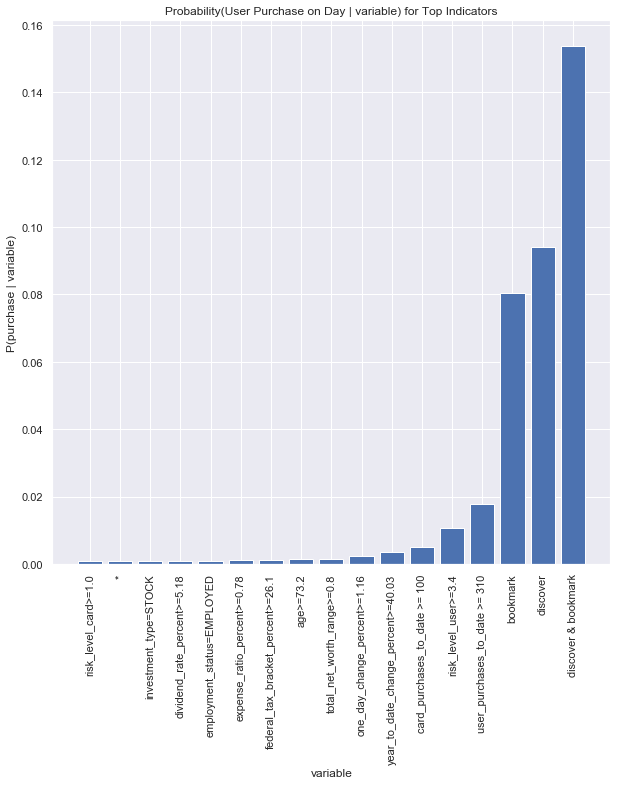

In [86]:
f = plt.figure(figsize=(10,10))
var_names = sorted((all_vars_probs.keys()), key=lambda x: all_vars_probs[x])
var_probs = sorted(all_vars_probs.values())
plt.bar(np.arange(len(all_vars_probs)), var_probs, 
        tick_label=var_names,
       )
plt.xticks(rotation=90)
plt.title("Probability(User Purchase on Day | variable) for Top Indicators")
plt.xlabel('variable')
plt.ylabel("P(purchase | variable)")

In [87]:
all_vars_probs

{'employment_status=EMPLOYED': 0.000913603824419341,
 'investment_type=STOCK': 0.0008374474819089384,
 'risk_level_user>=3.4': 0.010804036968245799,
 'age>=73.2': 0.0014119715844327968,
 'total_net_worth_range>=0.8': 0.0015751854096870356,
 'federal_tax_bracket_percent>=26.1': 0.001338600148565474,
 'risk_level_card>=1.0': 0.0008342815211932769,
 'dividend_rate_percent>=5.18': 0.0008594180630652523,
 'expense_ratio_percent>=0.78': 0.001091905395060236,
 'one_day_change_percent>=1.16': 0.002497161284023677,
 'year_to_date_change_percent>=40.03': 0.003703264627355042,
 'discover': 0.09424035122359145,
 'bookmark': 0.08044425726337015,
 'discover & bookmark': 0.15364834458373514,
 '*': 0.0008342815211932769,
 'user_purchases_to_date >= 310': 0.017836707936307126,
 'card_purchases_to_date >= 100': 0.004948023882019566}

Visting the discover page and bookmarking a stock has the largest impact on the probability of a user 
purchasing an investment on a certain day--a 15% probability of purchasing on that day. 

Beyond users 
bookmarking and/or discovering a stock on that day, having a large number of purchases prior to that day 
(having purchased that card more than 100 times before that day gives you P(purchase)>0.01, and having more than 
310 purchases gives you P(purchase)>0.004, both of which are significantly higher than the base P(purchase)=0.0009). 
At the same time, those two thresholds are pretty extreme and it is unlikely that 
a normal user will have that many purchases. Overall, I will say that the four attributes that affect purchases 
most are **having bookmarked or viewed the discover page of the stock/ETF, and having previously bought the stock/etf, or having purchased anything previously in general.**

**Recommendations:**

One could say that if a user 'discovered' a stock before purchasing it, they learned about it and were convinced to purchase it. 
If that is the case, then encouraging more users to visit the discover pages and learn could increase purchases. Stash could 
attempt to promote discover pages and see if that increases purchases. Perhaps a certain subset of users if more likely to be 
receptive to this, so it could be useful to perform an analysis of user purchasing patterns based on being promoted things, if 
experiments like this have been run in the past. 

As for users that have past purchase activity being more likely to purchase again--maybe a subset of these people use Stash 
because they just need a platform to invest and they would invest no matter what. Maybe this is also a subset of people who 
invested, and were satisfied with seeing their investments grow, and became more engaged with the app over time. 
Trying to identify those people, their demographics, and target others like them might also be a good idea.

**Other data that would be helpful:**
- Metadata about the stock/ETF at the time that it was purchased, rather than the static table that we have
- Other information about user engagement in the app. I imagine with any app there are a good chunk of users who install the 
app and forget about it, or forget about it after a certain point. In the users in the subset provided did visited some 
discover page at least once, so they have engaged with the app in some way. Maybe information about if users logged into the app 
on a certain day?
- Information on users' responsiveness to promotions/push notifications. This would be helpful if we are considering taking 
action to promote things to certain users to encourage them to make more purchases.

**Last thoughts/other things to do:**

- I would have liked to pay more attention to the counts of people that fall into the buckets that I was using to calculate 
probabilities, as calculating this off a group with very few users/events represented can lead to misleading statistics
- Calculating the probability of purchasing on a day may not be a good idea, because it is not independent of a user 
purchasing on a previous day (for example, if a user purchased yesterday, they might wait a bit until they purchase again)